In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics 
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import random

pd.set_option('display.max_columns', 50)

In [2]:
class Encoder(nn.Module):

    def __init__(self, n_inputs, thetas):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_inputs, (n_inputs+thetas[0])),
            nn.Tanh(),
            nn.Linear((n_inputs+thetas[0]), (n_inputs+thetas[1])),
            nn.Tanh(),
            nn.Linear((n_inputs+thetas[1]), (n_inputs+thetas[2]))
        )
        
    def forward(self, input_): 
        x = self.encoder(input_)
        
        return x
    
    
class Decoder(nn.Module):
    def __init__(self, n_inputs, theta):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear((n_inputs+thetas[2]), (n_inputs+thetas[1])),
            nn.Tanh(),
            nn.Linear((n_inputs+thetas[1]), (n_inputs+thetas[0])),
            nn.Tanh(),
            nn.Linear((n_inputs+thetas[0]), n_inputs)
            
        )
        
    def forward(self, input_):
            x = self.decoder(input_)

            return x
        
              
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight) 

In [3]:
def train_epoch(input_):
    encoder.train()
    decoder.train()
    
    dropout = nn.Dropout(.5)
    input_ = dropout(input_)
    
    encoded_data = encoder(input_)
    decoded_data = decoder(encoded_data)
    
    loss = loss_fn(decoded_data, input_)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()


def predict_DAE(df, missing_dict):
    
    predicted = list()
    for i in range(5):
        PATH_E = 'models/enc' + str(i) + '.pth'
        PATH_D = 'models/dec' + str(i) + '.pth'
        
        encoder.load_state_dict(T.load(PATH_E))
        decoder.load_state_dict(T.load(PATH_D))
        
        encoder.eval()
        decoder.eval()
        
        input_ = T.FloatTensor(df.values)
        encoded_data = encoder(input_)
        decoded_data = decoder(encoded_data) 
        
        predicted.append(decoded_data.detach().numpy())
        
        
    return predicted
        

def calculate_predicted_means(predicted_data):
    
    sum_pred = sum(predicted_data)
    mean_pred = sum_pred / len(predicted_data)
    
    return mean_pred

In [4]:
def random_attributes(df_):
    
    n_attributes = df_.shape[1]
    n_attributes_samples = int(round(n_attributes / 2, 0))
    random_indexes = random.sample(range(n_attributes), n_attributes_samples)
    random_indexes.sort()
    
    return random_indexes


def mcar_uniform(v_, df_):
    
    df2 = df_.mask(v_ <= 0.2, np.nan)
    
    missing_values = dict()
    for column in df2.columns.tolist():
        missing_values[column] = df2[df2[column].isnull()].index.tolist()
        
    df2.fillna(0, inplace=True)
    
    return df2, missing_values


def mcar_random(v_, df_):
    
    random_indexes = random_attributes(df_)
    
    selected_cols = np.array(df_.columns.tolist())[random_indexes]
    v__ = v_[:, random_indexes]
    
    df2, missing_values = mcar_uniform(v__, df_[selected_cols].copy())
    
    for c in selected_cols:
        df_[c] = df2[c]
    
    return df_, missing_values


def mnar_random(df_, selected_indexes=None):
    
    missing_values = dict()
    if selected_indexes is None:
        selected_indexes = np.random.choice(df_.columns.tolist(), 2)

    m1 = np.quantile(df_.loc[:, selected_indexes[0]], .8)
    m2 = np.quantile(df_.loc[:, selected_indexes[1]], .2)

    m1df = df_[df_.loc[:, selected_indexes[0]] >= m1].copy()
    m2df = df_[df_.loc[:, selected_indexes[1]] <= m2].copy()    

    m1df.loc[m1df.sample(frac=0.5).index, selected_indexes[0]] = np.nan
    m2df.loc[m2df.sample(frac=0.5).index, selected_indexes[1]] = np.nan
    
    missing_values[selected_indexes[0]] = m1df[m1df[selected_indexes[0]].isnull()].index.tolist()
    missing_values[selected_indexes[1]] = m2df[m2df[selected_indexes[1]].isnull()].index.tolist()
    
    df_.loc[m1df.index,  selected_indexes[0]] = m1df[selected_indexes[0]]
    df_.loc[m2df.index,  selected_indexes[1]] = m2df[selected_indexes[1]]
    
    df_.fillna(0, inplace=True)
    
    return df_, selected_indexes, missing_values

In [5]:
def calculate_rmse_sum(test_data, predicted, missing_values):
    rmse_sum = 0
    for column_name in missing_values.keys():
        missing_indexes = missing_values[column_name]
        new_col_name = 'miss_' + column_name
        test_data[new_col_name] = predicted[:, test_data.columns.tolist().index(column_name)]
        root_mse = np.sqrt(metrics.mean_squared_error(
            test_data.loc[missing_indexes, column_name],
                                            test_data.loc[missing_indexes, new_col_name]))
        rmse_sum += root_mse

    return rmse_sum

In [6]:
# Loading data

In [7]:
df = pd.read_csv('boston.csv')
y = df.MEDV
droplist = ['MEDV']
df.drop(droplist, axis=1,inplace=True)

In [8]:
# Standardizing the dataset and train-test split

In [9]:
min_max_scaler = preprocessing.MinMaxScaler()
df_ = min_max_scaler.fit_transform(df.copy())
df_ = pd.DataFrame(df_, columns=df.columns)
X_train, X_test, y_train, y_test = train_test_split(df_, y, test_size=0.3, random_state=42)

In [10]:
# Training DAE

Selected device: cpu
Episode: 10 current loss: 0.10750680416822433
Episode: 20 current loss: 0.05192990802849332
Episode: 30 current loss: 0.026730177458375692
Episode: 40 current loss: 0.012732893771802386
Episode: 50 current loss: 0.00815764038513104
Episode: 60 current loss: 0.006959930139904221
Episode: 70 current loss: 0.005086845601908863
Episode: 80 current loss: 0.004589003045111895
Episode: 90 current loss: 0.0031848545477259904
Episode: 100 current loss: 0.0031165723824718348
Episode: 110 current loss: 0.0024131254758685827
Episode: 120 current loss: 0.0025583030461954572
Episode: 130 current loss: 0.002913341003780564
Episode: 140 current loss: 0.002784157230053097
Episode: 150 current loss: 0.0018241376092191786
Episode: 160 current loss: 0.001998240884859115
Episode: 170 current loss: 0.0012098079508480926
Episode: 180 current loss: 0.0013527839910238981
Episode: 190 current loss: 0.0011828722393450637
Episode: 200 current loss: 0.0008642548831024518
Episode: 210 current l

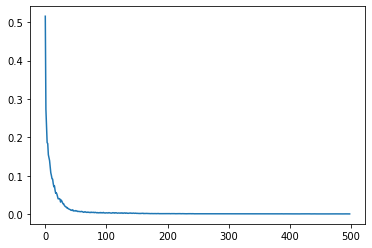

Episode: 10 current loss: 0.10468780994415283
Episode: 20 current loss: 0.04953763789186875
Episode: 30 current loss: 0.02642183316250642
Episode: 40 current loss: 0.01645902544260025
Episode: 50 current loss: 0.012197324773296714
Episode: 60 current loss: 0.006453732824108253
Episode: 70 current loss: 0.004888566113853206
Episode: 80 current loss: 0.004575713304802775
Episode: 90 current loss: 0.004001937457360327
Episode: 100 current loss: 0.0026427435028987625
Episode: 110 current loss: 0.003156806662445888
Episode: 120 current loss: 0.0022575084149139
Episode: 130 current loss: 0.002103855280438438
Episode: 140 current loss: 0.001794773736037314
Episode: 150 current loss: 0.0024249733445079378
Episode: 160 current loss: 0.0014718900783918798
Episode: 170 current loss: 0.0028073644692388675
Episode: 180 current loss: 0.0016321996566451464
Episode: 190 current loss: 0.0025345358008053154
Episode: 200 current loss: 0.001454944863022926
Episode: 210 current loss: 0.002579100546427071
E

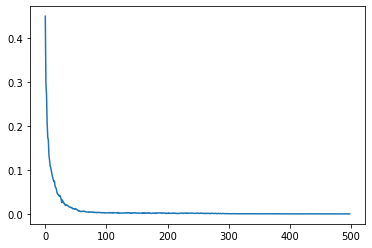

Episode: 10 current loss: 0.10904451770087083
Episode: 20 current loss: 0.05454825113217036
Episode: 30 current loss: 0.03486289487530788
Episode: 40 current loss: 0.017285301233641803
Episode: 50 current loss: 0.007988618453964591
Episode: 60 current loss: 0.006762797905442615
Episode: 70 current loss: 0.0042666483398837345
Episode: 80 current loss: 0.003286874465023478
Episode: 90 current loss: 0.0033832901972346008
Episode: 100 current loss: 0.002848489908501506
Episode: 110 current loss: 0.0028821989253629
Episode: 120 current loss: 0.0019391263097835083
Episode: 130 current loss: 0.0019821306535353265
Episode: 140 current loss: 0.001893105295797189
Episode: 150 current loss: 0.0015398151978539925
Episode: 160 current loss: 0.0010729569039540365
Episode: 170 current loss: 0.0011229531955905259
Episode: 180 current loss: 0.0009148616372840479
Episode: 190 current loss: 0.0010096188440608482
Episode: 200 current loss: 0.0009256740546940515
Episode: 210 current loss: 0.000751323546865

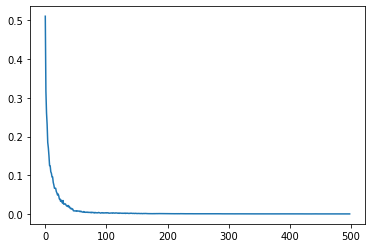

Episode: 10 current loss: 0.10092732310295105
Episode: 20 current loss: 0.05353247777869304
Episode: 30 current loss: 0.029691266206403572
Episode: 40 current loss: 0.01862678265509506
Episode: 50 current loss: 0.011650805982450644
Episode: 60 current loss: 0.0085262565407902
Episode: 70 current loss: 0.0053009655481825275
Episode: 80 current loss: 0.004957438330166042
Episode: 90 current loss: 0.0036598796335359416
Episode: 100 current loss: 0.002837423603826513
Episode: 110 current loss: 0.0025642641509572663
Episode: 120 current loss: 0.0024344478636824838
Episode: 130 current loss: 0.0017804099479690194
Episode: 140 current loss: 0.0016173928743228316
Episode: 150 current loss: 0.0012456382634506251
Episode: 160 current loss: 0.0011465831727643188
Episode: 170 current loss: 0.0010334224740896996
Episode: 180 current loss: 0.0009453972549332926
Episode: 190 current loss: 0.0011069930672723178
Episode: 200 current loss: 0.0008594332854651535
Episode: 210 current loss: 0.0008712116784

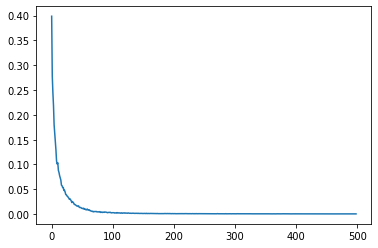

Episode: 10 current loss: 0.1280479940275351
Episode: 20 current loss: 0.06667338932553928
Episode: 30 current loss: 0.032643691481401525
Episode: 40 current loss: 0.020028678933158517
Episode: 50 current loss: 0.009097114166555306
Episode: 60 current loss: 0.006234649879237016
Episode: 70 current loss: 0.005454525526147336
Episode: 80 current loss: 0.004746633863154178
Episode: 90 current loss: 0.003859583792897562
Episode: 100 current loss: 0.00414031066854174
Episode: 110 current loss: 0.0032951689208857715
Episode: 120 current loss: 0.002235292641368384
Episode: 130 current loss: 0.0027266770193818957
Episode: 140 current loss: 0.002500142145436257
Episode: 150 current loss: 0.001985313841335786
Episode: 160 current loss: 0.002048572486576935
Episode: 170 current loss: 0.00263596591927732
Episode: 180 current loss: 0.002051330632336127
Episode: 190 current loss: 0.002228592512741064
Episode: 200 current loss: 0.001331077500556906
Episode: 210 current loss: 0.0017334970810528223
Epi

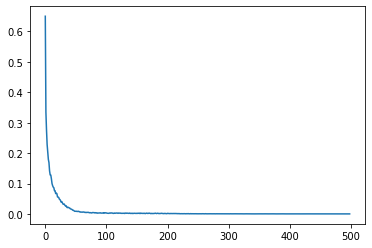

In [11]:
loss_fn = nn.MSELoss()

theta = 7
thetas = [theta * x for x in range(1,4)]

device = T.device("cuda") if T.cuda.is_available() else T.device("cpu")
print(f'Selected device: {device}')

tensordata = TensorDataset(T.FloatTensor(X_train.values), T.FloatTensor(y_train.values))
loader = DataLoader(tensordata, batch_size=32, pin_memory=True)
    
for k in range(5):
    
    PATH_E = 'models/enc' + str(k) + '.pth'
    PATH_D = 'models/dec' + str(k) + '.pth'

    encoder = Encoder(df.shape[1], thetas)
    decoder = Decoder(df.shape[1], thetas)

    encoder.apply(init_weights)
    decoder.apply(init_weights)

    dae_params = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    
    optimizer = T.optim.SGD(dae_params, lr=0.01, momentum=0.99, nesterov=True)

    encoder.to(device)
    decoder.to(device)  

    train_loss = dict()
    window_size = 30

    for e in range(1, 500):
        episode_loss= list()

        for batch_ndx, (X, y) in enumerate(loader):
            loss = train_epoch(X)
            episode_loss.append(loss)

        episode_mean = np.mean(episode_loss)
        
        
        SMA = round((sum(list(train_loss.values())[-window_size:]) / window_size), 3)
        current_mean_loss = round(episode_mean, 3)
        
        if episode_mean <= 1e-06: # or SMA < current_mean_loss:
                print(episode_mean)
                break
                   
        train_loss[e] = episode_mean   
         
        if e % 10 == 0:
                print(f"Episode: {e} current loss: {train_loss[e]}")

    T.save(encoder.state_dict(), PATH_E)
    T.save(decoder.state_dict(), PATH_D)
    plt.plot(train_loss.values())
    plt.show()

In [12]:
# DAE prediction

In [13]:
# create an uniform matrix
uniform_vector = np.random.uniform(size=X_test.shape)

# mnar/mcar
mnar_random_df, choosed_column_idx, missing_values_mnar = mnar_random(X_test.copy())
mcar_uniform_df, missing_values_mcar_uni = mcar_uniform(uniform_vector, X_test.copy())
mcar_random_df, missing_values_mcar_rand = mcar_random(uniform_vector, X_test.copy())

predicted_data = predict_DAE(mnar_random_df, missing_values_mnar)  
mnar_decoded_data = calculate_predicted_means(predicted_data)
mnar_random_rmse_sum = calculate_rmse_sum(X_test.copy(), mnar_decoded_data, 
                                         missing_values_mnar)
print(f"Mnar random test set rmse: {mnar_random_rmse_sum}")

# mcar uniform
predicted_data = predict_DAE(mcar_uniform_df, missing_values_mcar_uni)  
mcar_uni_decoded_data = calculate_predicted_means(predicted_data)

mcar_uni_rmse_sum = calculate_rmse_sum(X_test.copy(), mcar_uni_decoded_data,
                                      missing_values_mcar_uni)
print(f"Mcar uniform test set rmse: {mcar_uni_rmse_sum}")

# mnar random
predicted_data = predict_DAE(mcar_random_df, missing_values_mcar_rand)  
mcar_rnd_decoded_data = calculate_predicted_means(predicted_data)

mcar_random_rmse_sum = calculate_rmse_sum(X_test.copy(), mcar_rnd_decoded_data,
                                         missing_values_mcar_rand)
print(f"Mcar random test set rmse: {mcar_random_rmse_sum}")

Mnar random test set rmse: 1.0421044094953946
Mcar uniform test set rmse: 6.452182980277585
Mcar random test set rmse: 3.0607833655299084


In [14]:
# MICE training

In [15]:
uniform_vector_train = np.random.uniform(size=X_train.shape)
mnar_random_train, _,_ = mnar_random(X_train.copy(), choosed_column_idx)
mcar_random_train, _ = mcar_random(uniform_vector_train, X_train.copy())
mcar_uniform_train, _ = mcar_uniform(uniform_vector_train, X_train.copy())

In [16]:
rf = RandomForestRegressor()
mice_mnar_random = IterativeImputer(estimator=rf, verbose=0, max_iter=5, tol=1e-06, imputation_order='random', random_state=92)
mice_mnar_random.fit_transform(mnar_random_train.copy())

rf = RandomForestRegressor()
mice_mcar_random = IterativeImputer(estimator=rf, verbose=0, max_iter=5, tol=1e-06, imputation_order='random', random_state=92)
mice_mcar_random.fit_transform(mcar_random_train.copy())

rf = RandomForestRegressor()
mice_mcar_uniform = IterativeImputer(estimator=rf, verbose=0, max_iter=5, tol=1e-06, imputation_order='random', random_state=92)
mice_mcar_uniform.fit_transform(mcar_uniform_train.copy())

array([[2.64471527e-04, 0.00000000e+00, 6.30498534e-02, ...,
        6.48936170e-01, 9.92990065e-01, 9.60264901e-02],
       [1.40789220e-03, 0.00000000e+00, 0.00000000e+00, ...,
        5.53191489e-01, 9.90922386e-01, 2.84492274e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.63829787e-01, 1.00000000e+00, 0.00000000e+00],
       ...,
       [9.76735048e-05, 8.00000000e-01, 5.68181818e-02, ...,
        4.68085106e-01, 9.84971506e-01, 1.17549669e-01],
       [0.00000000e+00, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 0.00000000e+00, 5.94370861e-01],
       [2.50017197e-03, 0.00000000e+00, 2.96920821e-01, ...,
        8.82978723e-01, 1.77719502e-01, 2.45584989e-01]])

In [17]:
# MICE predicting and comparing the results

In [18]:
mice_mnar_random_test = mice_mnar_random.transform(mnar_random_df.copy())
mice_mnar_random_rmse_sum = calculate_rmse_sum(X_test, mice_mnar_random_test, missing_values_mnar)
print(f"MICE Mnar random test set rmse: {mice_mnar_random_rmse_sum}")
print(f"DAE Mnar random test set rmse: {mnar_random_rmse_sum}")

MICE Mnar random test set rmse: 0.9688978566395455
DAE Mnar random test set rmse: 1.0421044094953946


In [19]:
mice_mcar_random_test = mice_mcar_random.transform(mcar_random_df.copy())
mice_mcar_random_rmse_sum = calculate_rmse_sum(X_test, mice_mcar_random_test, missing_values_mcar_rand)
print(f"MICE Mcar random test set rmse: {mice_mcar_random_rmse_sum}")
print(f"DAE Mcar random test set rmse: {mcar_random_rmse_sum}")

MICE Mcar random test set rmse: 2.886186692762375
DAE Mcar random test set rmse: 3.0607833655299084


In [20]:
mice_mcar_uniform_test = mice_mcar_uniform.transform(mcar_uniform_df.copy())
mice_mcar_uniform_rmse_sum = calculate_rmse_sum(X_test, mice_mcar_uniform_test, missing_values_mcar_uni)
print(f"MICE Mcar uniform test set rmse: {mice_mcar_uniform_rmse_sum}")
print(f"DAE Mcar uniform test set rmse: {mcar_uni_rmse_sum}")

MICE Mcar uniform test set rmse: 6.190648597724493
DAE Mcar uniform test set rmse: 6.452182980277585
